# IMPORTS

In [ ]:
!pip install transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional,LSTM,GlobalAveragePooling1D,GlobalMaxPooling1D,Dropout,Dense,concatenate,Input
from tensorflow.keras.models import Model
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, TFBertModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive











.# Data loading and cleaning

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/twitter_training.csv")
data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [ ]:
df=data.copy()

In [ ]:
#Changing the name of cloumns to make more meaningful
df=df.rename(columns={'Positive':'Sentiment','im getting on borderlands and i will murder you all ,':'Tweet'})

In [ ]:
#Removing the columns that ww won't need for model training
df=df.drop(['2401','Borderlands'],axis=1)

In [ ]:
#We are only interested in Positive, Negative and Normal cases so lets dop Irrelevant
indexes=[]
for i in range(74681):
    if(df['Sentiment'][i]=='Irrelevant'):
        indexes.append(i)

In [ ]:
df=df.drop(indexes,axis=0)

In [ ]:
#Checking for null values
df.isna().sum()

Sentiment      0
Tweet        571
dtype: int64

In [ ]:
#Dropping null values
df=df.dropna()

In [ ]:
#Handling categorical nature of our target variable
df['Sentiment']=df['Sentiment'].map({'Positive':2,'Neutral':1,'Negative':0})

In [ ]:
#Reset the index
df.reset_index(inplace=True)

In [ ]:
# Data cleaning
def clean(df):
    df=re.sub('[^a-zA-Z]',' ',df)
    df=df.lower()
    return df
df['Tweet']=df['Tweet'].apply(clean)

In [ ]:
# For getting max_length
df['Len']=df['Tweet'].apply(lambda x:len(x.split()))
df['Len'].max()

166

In [ ]:
x=df['Tweet']
y=df['Sentiment']

In [ ]:
#Splitting data as train, test, validation
x_train,x_t,y_train,y_t=train_test_split(x,y,random_state=42)

In [ ]:
x_valid=x_t[:int(x_t.shape[0]*0.35)]
y_valid=y_t[:int(y_t.shape[0]*0.35)]
x_test=x_t[int(x_t.shape[0]*0.35):]
y_test=y_t[int(y_t.shape[0]*0.35):]

# Data preprocessing and model

In [ ]:
tokenizer=AutoTokenizer.from_pretrained('bert-base-uncased')
bert=TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Convering data into format that bert accepts
X_train=tokenizer(text=x_train.tolist(),
                 add_special_tokens=True,
                 max_length=166,
                 truncation=True,
                 padding='max_length',
                 return_tensors='tf',
                 return_token_type_ids=False,
                 return_attention_mask=True,
                 verbose=True)
X_test=tokenizer(text=x_test.tolist(),
                 add_special_tokens=True,
                 max_length=166,
                 truncation=True,
                 padding='max_length',
                 return_tensors='tf',
                 return_token_type_ids=False,
                 return_attention_mask=True,
                 verbose=True)
X_valid=tokenizer(text=x_valid.tolist(),
                 add_special_tokens=True,
                 max_length=166,
                 truncation=True,
                 padding='max_length',
                 return_tensors='tf',
                 return_token_type_ids=False,
                 return_attention_mask=True,
                 verbose=True)

In [ ]:
#fine tuning bert model
max_len=166
input_ids=Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
input_mask=Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')
output=bert(input_ids,attention_mask=input_mask)
bert.trainable=False

#adding custom layers
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(output['last_hidden_state'])
avg_pool = GlobalAveragePooling1D()(bi_lstm)
max_pool = GlobalMaxPooling1D()(bi_lstm)
concat = concatenate([avg_pool, max_pool])
dropout = Dropout(0.3)(concat)
output = Dense(3, activation="softmax")(dropout)
model = Model(inputs=[input_ids, input_mask], 
                                  outputs=output)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 166)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 166)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 166,                                           

# Model training and evaluation

In [ ]:
total_samples=x_train.shape[0]
batch_size=32

In [ ]:
h=model.fit(x={'input_ids':X_train['input_ids'],'attention_mask':X_train['attention_mask']},
           y=tf.keras.utils.to_categorical(y_train),
           validation_data=({'input_ids':X_valid['input_ids'],'attention_mask':X_valid['attention_mask']},tf.keras.utils.to_categorical(y_valid)),
           epochs=20,
           
           steps_per_epoch=total_samples//batch_size)

Epoch 1/20
1432/1432 [==============================] - 704s 476ms/step - loss: 0.7887 - accuracy: 0.6516 - val_loss: 0.6992 - val_accuracy: 0.7016
Epoch 2/20
1432/1432 [==============================] - 677s 473ms/step - loss: 0.6943 - accuracy: 0.7016 - val_loss: 0.6292 - val_accuracy: 0.7317
Epoch 3/20
1432/1432 [==============================] - 677s 473ms/step - loss: 0.6237 - accuracy: 0.7355 - val_loss: 0.5719 - val_accuracy: 0.7644
Epoch 4/20
1432/1432 [==============================] - 677s 472ms/step - loss: 0.5612 - accuracy: 0.7669 - val_loss: 0.5228 - val_accuracy: 0.7866
Epoch 5/20
1432/1432 [==============================] - 673s 470ms/step - loss: 0.4948 - accuracy: 0.7976 - val_loss: 0.4683 - val_accuracy: 0.8141
Epoch 6/20
1432/1432 [==============================] - 672s 469ms/step - loss: 0.4436 - accuracy: 0.8212 - val_loss: 0.4256 - val_accuracy: 0.8347
Epoch 7/20
1432/1432 [==============================] - 672s 470ms/step - loss: 0.3916 - accuracy: 0.8425 - val_

1432/1432 [==============================] - 327s 228ms/step - loss: 0.2058 - accuracy: 0.9182 - val_loss: 0.2566 - val_accuracy: 0.9022


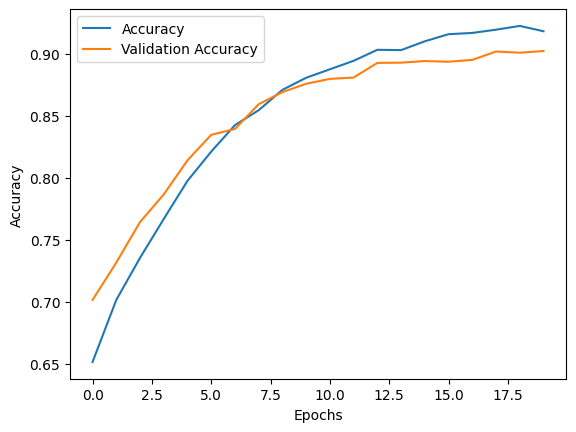

In [ ]:
plt.plot(h.history['accuracy'],label='Accuracy')
plt.plot(h.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

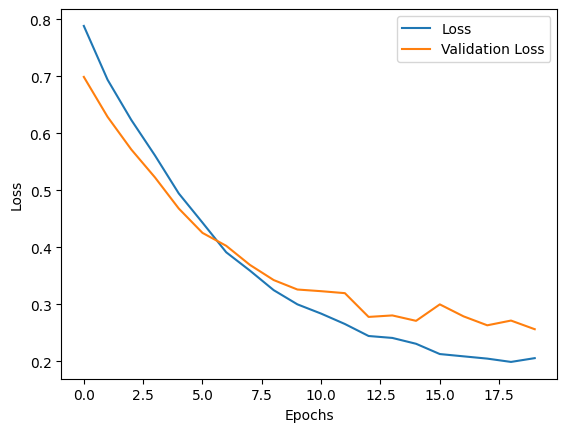

In [ ]:
plt.plot(h.history['loss'],label='Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()